# Article Page Views Analysis
This notebook collects article traffic data from 2015-2024 using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API), and conducts basic visual analysis through graphing specific subsets of the data as timeseries.


The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use the API.

## License
This code builds upon an [example code](https://drive.google.com/file/d/1fYTIX79t9jk-Jske8IwysV-rbRkD4_dc/view?usp=drive_link) that was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. The example code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024


In [1]:
import json, time, urllib.parse
import requests
import pandas as pd
import matplotlib.pyplot as plt

Setting parameters

In [2]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<zwang28@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests

rare_disease_df = pd.read_csv('./rare-disease_cleaned.AUG.2024.csv')
ARTICLE_TITLES = rare_disease_df['disease'].tolist()


# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2024093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2024093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2024093000"    # this is likely the wrong end date
}

In [3]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = None,
                                  headers = REQUEST_HEADERS):
    """
    This function returns a JSON response as the result of retrieving article traffic data from the API.
    """
    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe = '')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Get pageview data for mobile, and save as a json file called 'rare-disease_monthly_mobile_start201507-end202409.json'

In [4]:
# remove the 'access' field for mobile files.
# resulting datasets should be saved as JSON files ordered using article titles as a key 
# for the resulting time series data for that article. 

views_mobile = {}

for article_title in ARTICLE_TITLES: 
    result_app = request_pageviews_per_article(article_title=article_title, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)
    result_web = request_pageviews_per_article(article_title=article_title, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
    
    if 'items' in result_app: # make sure there's data to process
        article_data = []
        for i in range(len(result_app['items'])):
            views_data = {}
            views_data['project'] = result_app['items'][i]['project']
            views_data['article'] = result_app['items'][i]['article']
            views_data['granularity'] = result_app['items'][i]['granularity']
            views_data['timestamp'] = result_app['items'][i]['timestamp']
            views_data['agent'] = result_app['items'][i]['agent']
            views_data['views'] = result_app['items'][i]['views'] + result_web['items'][i]['views']  # Sum the views
        
            article_data.append(views_data)
        views_mobile[article_title] = article_data

In [5]:
len(views_mobile)

1773

In [6]:
# save to a JSON file
with open('rare-disease_monthly_mobile_start201507-end202409.json', 'w') as f:
    json.dump(views_mobile, f, indent=4)

Get pageview data for desktop, and saves as a json file called 'rare-disease_monthly_desktop_start201507-end202409.json'

In [7]:
views_desktop = {}

for article_title in ARTICLE_TITLES:
    result = request_pageviews_per_article(article_title=article_title, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP)
    if 'items' in result:
        article_data = []
        article_data.extend(result['items']) 
        
        views_desktop[article_title] = article_data

        
# save to a JSON file
with open('rare-disease_monthly_desktop_start201507-end202409.json', 'w') as f:
    json.dump(views_desktop, f, indent=4) # 'indent=4' formats the JSON file with 4-space indentation for readability

Get pageview data for sum of all mobile, and all desktop traffic per article, and saves as a json file called 'rare-disease_monthly_cumulative_start201507-end202409.json'

In [10]:
# remove the 'access' field for cumulative files.
# resulting datasets should be saved as JSON files ordered using article titles as a key 
# for the resulting time series data for that article. 

views_cumulative = {}

for article_title in ARTICLE_TITLES: 
    article_data = []
    
    desktop_data = views_desktop[article_title]
    mobile_data = views_mobile[article_title]

    for i in range(len(desktop_data)):
        views_data = {}

        views_data['project'] = desktop_data[i]['project']
        views_data['article'] = desktop_data[i]['article']
        views_data['granularity'] = desktop_data[i]['granularity']
        views_data['timestamp'] = desktop_data[i]['timestamp']
        views_data['agent'] = desktop_data[i]['agent']
        views_data['views'] = desktop_data[i]['views'] + mobile_data[i]['views']
        
        article_data.append(views_data)
    
    # Store the data for this article
    views_cumulative[article_title] = article_data



# save to a JSON file
with open('rare-disease_monthly_cumulative_start201507-end202409.json', 'w') as f:
    json.dump(views_cumulative, f, indent=4)

## Analysis

### Maximum Average and Minimum Average

This graph contains time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. The graph has four lines (max desktop, min desktop, max mobile, min mobile).


In [18]:
# get data from JSON files
with open('rare-disease_monthly_mobile_start201507-end202409.json', 'r') as f:
    mobile_data = json.load(f)
    
with open('rare-disease_monthly_desktop_start201507-end202409.json', 'r') as f:
    desktop_data = json.load(f)

In [20]:
# turn json data into dataframe

def flatten_data(data):
    flattened = []
    for article, entries in data.items():
        for entry in entries:
            entry['article'] = article
            flattened.append(entry)
    return flattened

mobile_flattened = flatten_data(mobile_data)
desktop_flattened = flatten_data(desktop_data)

mobile_df = pd.DataFrame(mobile_flattened)
desktop_df = pd.DataFrame(desktop_flattened)

In [22]:
mobile_df.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Klinefelter syndrome,monthly,2015070100,user,38513
1,en.wikipedia,Klinefelter syndrome,monthly,2015080100,user,34903
2,en.wikipedia,Klinefelter syndrome,monthly,2015090100,user,33557
3,en.wikipedia,Klinefelter syndrome,monthly,2015100100,user,36000
4,en.wikipedia,Klinefelter syndrome,monthly,2015110100,user,39945


In [23]:
# get the average pageviews for each article in both desktop and mobile data
desktop_avg_views = desktop_df.groupby("article")["views"].mean()
mobile_avg_views = mobile_df.groupby("article")["views"].mean()

max_desktop_article = desktop_avg_views.idxmax()
min_desktop_article = desktop_avg_views.idxmin()
max_mobile_article = mobile_avg_views.idxmax()
min_mobile_article = mobile_avg_views.idxmin()

print("max_desktop_article: ", max_desktop_article)
print("min_desktop_article: ", min_desktop_article)
print("max_mobile_article: ", max_mobile_article)
print("min_mobile_article: ", min_mobile_article)

max_desktop_article:  Black Death
min_desktop_article:  Filippi Syndrome
max_mobile_article:  Black Death
min_mobile_article:  Filippi Syndrome


In [25]:
# plot
max_desktop_df = desktop_df[desktop_df["article"] == max_desktop_article]
min_desktop_df = desktop_df[desktop_df["article"] == min_desktop_article]
max_mobile_df = mobile_df[mobile_df["article"] == max_mobile_article]
min_mobile_df = mobile_df[mobile_df["article"] == min_mobile_article]

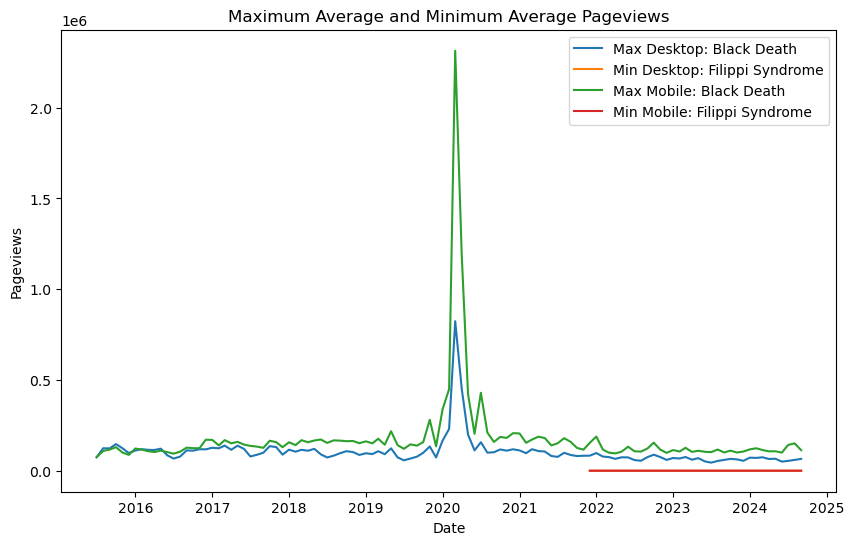

In [26]:
plt.figure(figsize=(10, 6))
_ = plt.plot(pd.to_datetime(max_desktop_df["timestamp"], format="%Y%m%d%H"), 
         max_desktop_df["views"], label=f'Max Desktop: {max_desktop_article}')

_ = plt.plot(pd.to_datetime(min_desktop_df["timestamp"], format="%Y%m%d%H"), 
         min_desktop_df["views"], label=f'Min Desktop: {min_desktop_article}')


_ = plt.plot(pd.to_datetime(max_mobile_df["timestamp"], format="%Y%m%d%H"), 
         max_mobile_df["views"], label=f'Max Mobile: {max_mobile_article}')

_ = plt.plot(pd.to_datetime(min_mobile_df["timestamp"], format="%Y%m%d%H"), 
         min_mobile_df["views"], label=f'Min Mobile: {min_mobile_article}')

_ = plt.title('Maximum Average and Minimum Average Pageviews')
_ = plt.xlabel('Date')
_ = plt.ylabel('Pageviews')
_ = plt.legend()


plt.savefig('img/Maximum_Average_and_Minimum_Average.png')

### Top 10 Peak Page Views

The second graph contains time series for the top 10 article pages by largest (peak) page views over the entire time series by access type. The graph contains the top 10 for desktop and top 10 for mobile access (20 lines).


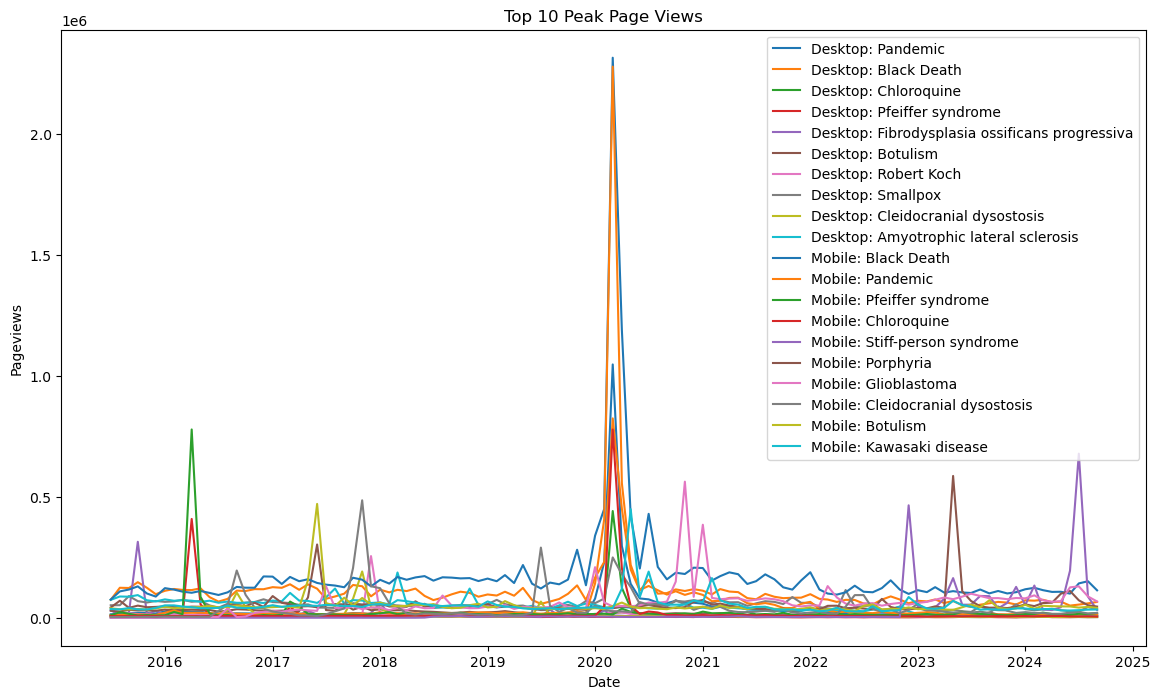

In [27]:
# first find the month for each article that contains the highest (peak) page views
peak_desktop = desktop_df.groupby("article")["views"].max().reset_index()
peak_desktop.columns = ["article", "peak_views"]

peak_mobile = mobile_df.groupby("article")["views"].max().reset_index()
peak_mobile.columns = ["article", "peak_views"]


# order the articles by these peak values to get the top 10 for desktop and mobile
top_10_desktop = peak_desktop.nlargest(10, "peak_views")
top_10_mobile = peak_mobile.nlargest(10, "peak_views")


top_10_desktop_df = desktop_df[desktop_df["article"].isin(top_10_desktop["article"])]
top_10_mobile_df = mobile_df[mobile_df["article"].isin(top_10_mobile["article"])]


_ = plt.figure(figsize=(14, 8))

# plot top 10 desktop articles
for article in top_10_desktop["article"]:
    article_data = top_10_desktop_df[top_10_desktop_df["article"] == article]
    _ = plt.plot(pd.to_datetime(article_data["timestamp"], format="%Y%m%d%H"), 
             article_data["views"], label=f'Desktop: {article}')

# plot top 10 mobile articles
for article in top_10_mobile["article"]:
    article_data = top_10_mobile_df[top_10_mobile_df["article"] == article]
    _ = plt.plot(pd.to_datetime(article_data["timestamp"], format="%Y%m%d%H"), 
             article_data["views"], label=f'Mobile: {article}')

_ = plt.title('Top 10 Peak Page Views')
_ = plt.xlabel('Date')
_ = plt.ylabel('Pageviews')
_ = plt.legend()

plt.savefig('img/Top_10_Peak_Page_Views.png')

### Fewest Months of Data 

The third graph shows pages that have the fewest months of available data. The graph contains the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

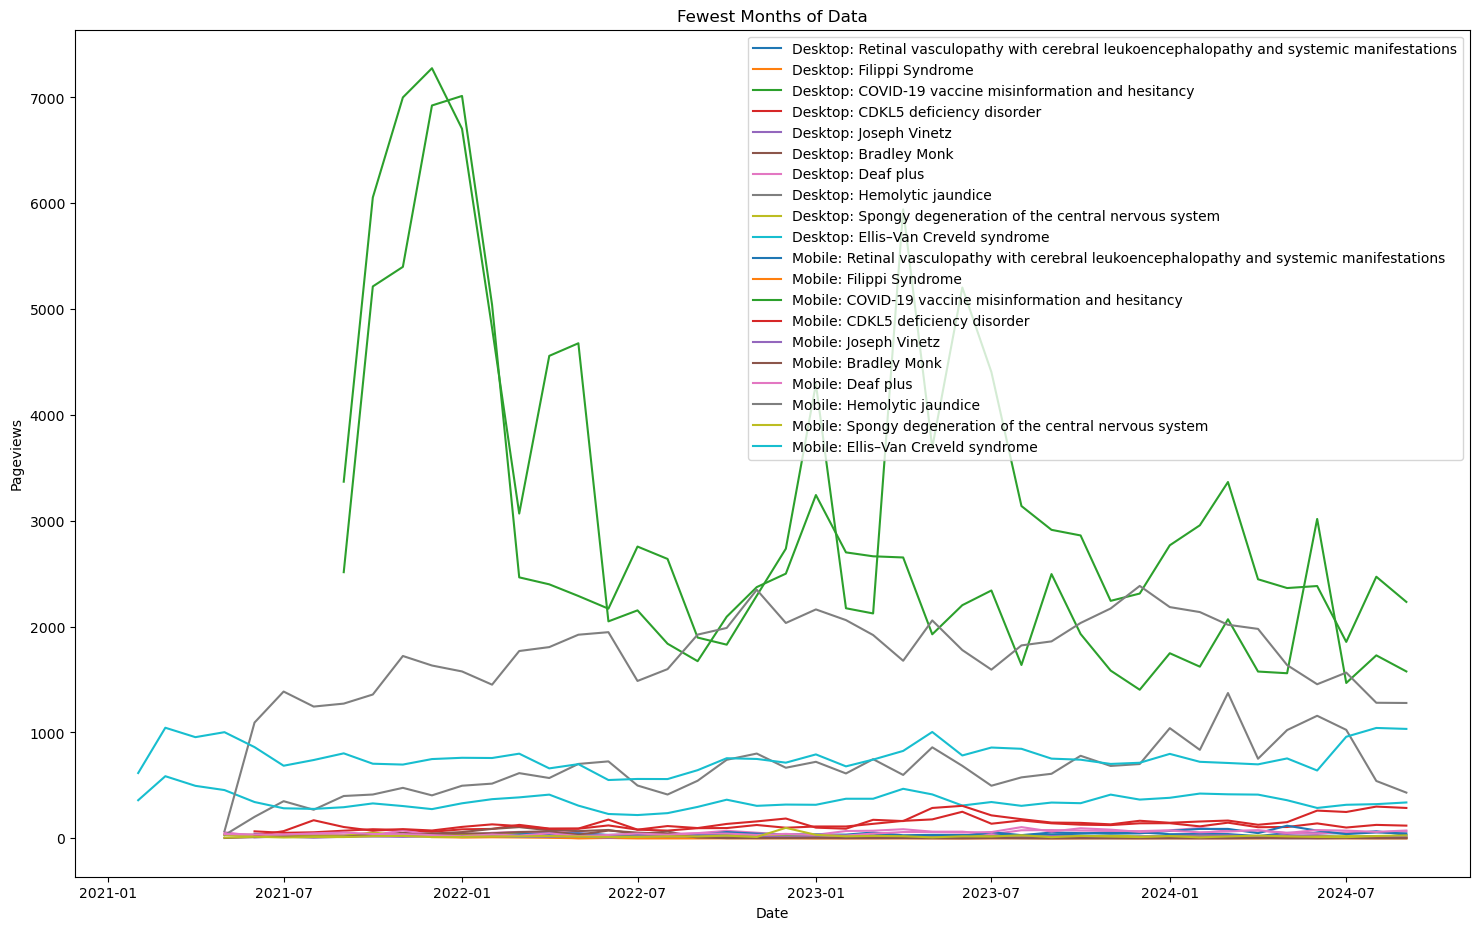

In [28]:
# desktop
fewest_data_desktop_df = desktop_df.groupby("article").count().reset_index()
fewest_data_desktop_df = fewest_data_desktop_df[["article", "views"]]

fewest_data_desktop_df.columns = ["article", "months_of_data"]
fewest_data_desktop_10 = fewest_data_desktop_df.nsmallest(10, "months_of_data")

# mobile
fewest_data_mobile_df = mobile_df.groupby("article").count().reset_index()
fewest_data_mobile_df = fewest_data_mobile_df[["article", "views"]]

fewest_data_mobile_df.columns = ["article", "months_of_data"]
fewest_data_mobile_10 = fewest_data_mobile_df.nsmallest(10, "months_of_data")

# get all months of available data
fewest_10_desktop_df = desktop_df[desktop_df["article"].isin(fewest_data_desktop_10["article"])]
fewest_10_mobile_df = mobile_df[mobile_df["article"].isin(fewest_data_mobile_10["article"])]


_ = plt.figure(figsize=(18, 11))

# plot fewest 10 desktop articles
for article in fewest_data_desktop_10["article"]:
    article_data = fewest_10_desktop_df[fewest_10_desktop_df["article"] == article]
    _ = plt.plot(pd.to_datetime(article_data["timestamp"], format="%Y%m%d%H"), 
             article_data["views"], label=f'Desktop: {article}')

# plot fewest 10 mobile articles
for article in fewest_data_mobile_10["article"]:
    article_data = fewest_10_mobile_df[fewest_10_mobile_df["article"] == article]
    _ = plt.plot(pd.to_datetime(article_data["timestamp"], format="%Y%m%d%H"), 
             article_data["views"], label=f'Mobile: {article}')

_ = plt.title('Fewest Months of Data')
_ = plt.xlabel('Date')
_ = plt.ylabel('Pageviews')
_ = plt.legend()

plt.savefig('img/Fewest_Months_of_Data.png')